In [1]:
import pandas as pd
df=pd.read_csv (r"C:\Users\HP\Downloads\Crash_data_real.csv"
               )

In [3]:
df

,Subject_Vehicle,Gender,Age,Occupation_of_Driver,Education_Level,Driving_Experience,Institutional_Driving_Training,Driving_Duration,Driving_Income,Vehicle_Speed,Crash_Severity,Cause_of_Crash,Crash_Partner,Awareness_of_Traffic_Rules,Incident_Time
2090,Easy bike,Male,40,Driving,Primary,2.85,0,9,713,Medium,Non Injury,Non-expert driver,Easy bike,0,Day


In [4]:
df.drop (columns=['Gender'], inplace=True)
df.sample()

,Subject_Vehicle,Age,Occupation_of_Driver,Education_Level,Driving_Experience,Institutional_Driving_Training,Driving_Duration,Driving_Income,Vehicle_Speed,Crash_Severity,Cause_of_Crash,Crash_Partner,Awareness_of_Traffic_Rules,Incident_Time
1549,Easy bike,20,Driving,Primary,0.17,0,12,986,Medium,Non Injury,Non-expert driver,Easy bike,0,Day


In [5]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# STEP 1 
X= df.drop( columns=['Crash_Severity'])
y= df['Crash_Severity']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# STEP 2: Define column groups
nominal_cols = ['Subject_Vehicle','Occupation_of_Driver', 'Crash_Partner', 'Cause_of_Crash', 'Incident_Time']
numeric_cols = ['Age', 'Driving_Experience', 'Driving_Duration', 'Driving_Income']
ordinal_cols = ['Education_Level', 'Vehicle_Speed'] 
# label_col= ['Injury_Severity']
ordinal_order = [
    ['Illiterate', 'Primary', 'Secondary', 'H.Secondary', 'Graduate'],
    ['Low', 'Medium', 'High'] 
]

# STEP 3: Define transformers
preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_order), ordinal_cols),
    ('nom', OneHotEncoder(drop='first'), nominal_cols),
    # ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')  # binary features already encoded
# # Step 4: Define Scaling 
# feature_scaling= StandardScaler ()
# STEP 5: Build pipeline
pipeline = Pipeline(steps=[
    ('Preprocessing', preprocessor),
    # ('Scaling', feature_scaling)
])
print("Fitting pipeline on training data...")
X_train_transformed = pipeline.fit_transform(X_train)  # Fit and transform training data
X_test_transformed = pipeline.transform(X_test)        # Only transform test data (no fitting!)

print(f"Training data shape: {X_train_transformed.shape}")
print(f"Test data shape: {X_test_transformed.shape}")

Fitting pipeline on training data...
Training data shape: (2405, 28)
Test data shape: (602, 28)


In [7]:
# Reverse OneHot back to single numerical columns
def reverse_onehot_to_numerical(df_transformed, feature_names):
    df_reconstructed = pd.DataFrame()
    
    # Get feature name groups
    nominal_cols = ['Subject_Vehicle','Occupation_of_Driver', 'Crash_Partner', 'Cause_of_Crash', 'Incident_Time']
    
    i = 0
    # Handle each column type
    for col in ['Education_Level', 'Vehicle_Speed']:  # Ordinal - already numerical
        df_reconstructed[col] = df_transformed.iloc[:, i]
        i += 1
    
    # OneHot columns - convert back to single numerical column  
    for nom_col in nominal_cols:
        # Find all columns that belong to this feature
        onehot_cols = [name for name in feature_names if name.startswith(f'nom__{nom_col}_')]
        
        print(f"Found {len(onehot_cols)} OneHot columns for {nom_col}: {onehot_cols[:3]}...")  # Debug
        # Convert back to numerical (0, 1, 2, 3...)
        values = []
        for idx in range(len(df_transformed)):
            # Find which onehot column is 1
            found = False
            for j, oh_col in enumerate(onehot_cols):
                col_idx = feature_names.tolist().index(oh_col)
                if df_transformed.iloc[idx, col_idx] == 1:
                    values.append(j + 1)  # +1 because first category was dropped
                    found = True
                    break
            if not found:
                values.append(0)  # First category (was dropped)
        
        df_reconstructed[nom_col] = values
        i += len(onehot_cols)
    
    # Add remaining columns (numeric, binary)
    remaining_cols = ['Age', 'Driving_Experience', 'Driving_Duration', 'Driving_Income', 
                     'Institutional_Driving_Training', 'Awareness_of_Traffic_Rules']
    for col in remaining_cols:
        df_reconstructed[col] = df_transformed.iloc[:, i]
        i += 1
    
    return df_reconstructed

# Apply it
feature_names = pipeline.named_steps['Preprocessing'].get_feature_names_out()
X_train_15 = reverse_onehot_to_numerical(pd.DataFrame(X_train_transformed), feature_names)
X_test_16 = reverse_onehot_to_numerical(pd.DataFrame(X_test_transformed), feature_names)
# # Apply correct encoding

X_train_15.insert(0, 'Crash_Severity', y_train.values)
# le = LabelEncoder()
# X_train_15['Crash_Severity'] = le.fit_transform(X_train_15['Crash_Severity'])
X_test_16.insert(0, 'Crash_Severity', y_test.values)
# X_test_16['Crash_Severity'] = le.fit_transform(X_test_16['Crash_Severity'])
severity_mapping = {
    'Non Injury': 0,    # Lowest severity
    'Minor injury': 1,   # Medium severity  
    'Moderate injury': 2 ,
    'Serious': 3,
    'Fatality': 4
}
X_train_15['Crash_Severity'] = X_train_15['Crash_Severity'].map(severity_mapping)
X_test_16['Crash_Severity'] = X_test_16['Crash_Severity'].map(severity_mapping)
combined_df = pd.concat([X_train_15, X_test_16], axis=0).reset_index(drop=True)


# print(f"Reconstructed shape: {combined_df.shape}")  # Should be (2405, 15)

Found 4 OneHot columns for Subject_Vehicle: ['nom__Subject_Vehicle_Easy bike', 'nom__Subject_Vehicle_Leguna', 'nom__Subject_Vehicle_Rickshaw']...
Found 5 OneHot columns for Occupation_of_Driver: ['nom__Occupation_of_Driver_Care Taker', 'nom__Occupation_of_Driver_Day Labour', 'nom__Occupation_of_Driver_Driving']...
Found 7 OneHot columns for Crash_Partner: ['nom__Crash_Partner_Bus', 'nom__Crash_Partner_CNG', 'nom__Crash_Partner_Car']...
Found 3 OneHot columns for Cause_of_Crash: ['nom__Cause_of_Crash_Environmental  Effect', 'nom__Cause_of_Crash_Non-expert driver', 'nom__Cause_of_Crash_Talking on phone']...
Found 1 OneHot columns for Incident_Time: ['nom__Incident_Time_Night']...
Found 4 OneHot columns for Subject_Vehicle: ['nom__Subject_Vehicle_Easy bike', 'nom__Subject_Vehicle_Leguna', 'nom__Subject_Vehicle_Rickshaw']...
Found 5 OneHot columns for Occupation_of_Driver: ['nom__Occupation_of_Driver_Care Taker', 'nom__Occupation_of_Driver_Day Labour', 'nom__Occupation_of_Driver_Driving'].

In [8]:
combined_df.sample()

,Crash_Severity,Education_Level,Vehicle_Speed,Subject_Vehicle,Occupation_of_Driver,Crash_Partner,Cause_of_Crash,Incident_Time,Age,Driving_Experience,Driving_Duration,Driving_Income,Institutional_Driving_Training,Awareness_of_Traffic_Rules
1914,1,1.0,0.0,1,3,4,3,0,60.0,6.62,0.0,6.0,811.0,0.0


In [24]:
#combined_df.to_csv (Crash_data_Num.csv)

In [2]:
new_df=pd.read_csv (r"C:\Users\HP\Downloads\Crash_data_Num.csv")

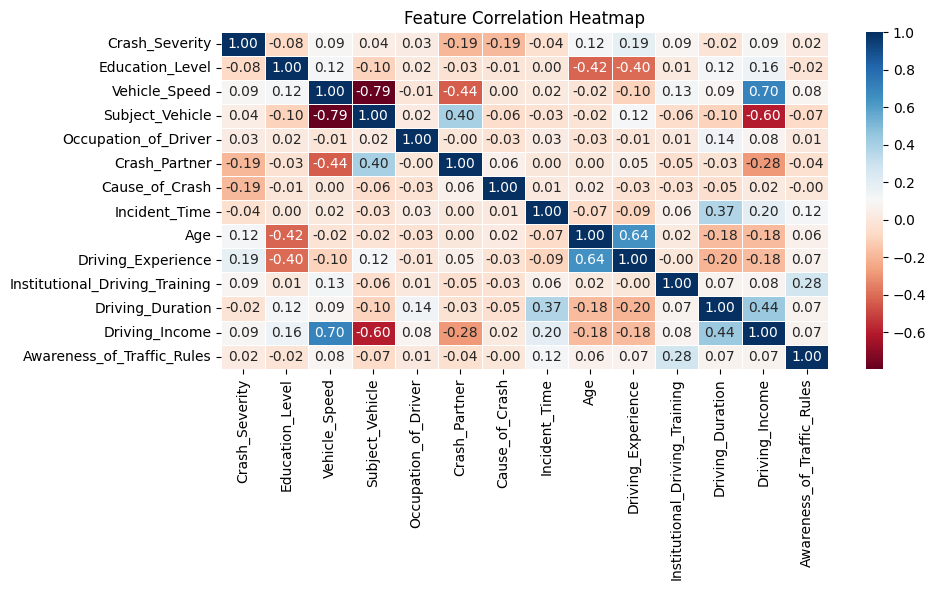

In [32]:
corr_matrix = new_df.corr().abs()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(new_df.corr (), 
            annot=True, 
            cmap='RdBu', 
            fmt=".2f", 
            # mask=mask,
            linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
# import pandas as pd
# import numpy as np
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calculate_vif_simple(df, target_column):
#     """
#     Calculate VIF for all columns except the target variable
    
#     Parameters:
#     df: your dataframe
#     target_column: name of your target variable (string)
#     """
    
#     # Remove target column from analysis
#     feature_data = df.drop(columns=[target_column])
    
#     # Calculate VIF for each feature
#     vif = pd.DataFrame()
#     vif["Feature"] = feature_data.columns
#     vif["VIF"] = [variance_inflation_factor(feature_data.values, i) 
#                   for i in range(len(feature_data.columns))]
    
#     # Sort by VIF value (highest first)
#     vif = vif.sort_values('VIF', ascending=False)
    
#     # Display results with interpretation
#     print("VIF Results (sorted by highest VIF):")
#     print("=" * 50)
#     for _, row in vif.iterrows():
#         status = "🔴 HIGH" if row['VIF'] > 10 else "🟡 MODERATE" if row['VIF'] > 5 else "🟢 LOW"
#         print(f"{row['Feature']:<25} VIF: {row['VIF']:>8.2f} {status}")
    
#     return vif

# # Usage:
# # Replace 'your_target_column_name' with your actual target column name
# # vif_results = calculate_vif_simple(df, 'your_target_column_name')

# # Example if your target is 'Crash_Severity':
# vif_results = calculate_vif_simple(new_df, 'Crash_Severity')
new_df['Crash_Severity'].value_counts()

Crash_Severity
0    2357
1     430
2     153
3      47
4      20
Name: count, dtype: int64

In [3]:
###Building the model
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# STEP 1: Prepare Data


### Random Forest Model
df2=new_df.drop(columns=['Driving_Income','Subject_Vehicle'])
X = df2.drop(columns=['Crash_Severity'])
y = df2['Crash_Severity']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
scale= StandardScaler ()
X_train_trf= scale.fit_transform (X_train)
X_test_trf= scale.transform (X_test)
rf= RandomForestClassifier(class_weight= 'balanced', n_jobs=-1, random_state=42)
param_grid = {
    'n_estimators': [25,50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [ 5,10,15],
    'bootstrap':[True, False]
}
grid= GridSearchCV (RandomForestClassifier (class_weight= 'balanced', n_jobs=-1), param_grid, cv=10, scoring='accuracy',verbose=1, n_jobs=-1)
grid.fit (X_train_trf, y_train)
print ('Best_Parameters', grid.best_params_)
print ('Best Accuracy', grid.best_score_)
                   
# # STEP 2: Define Column Groups and Orders
# nominal_cols = ['Occupation_of_Driver', 'Crash_Partner', 'Cause_of_Crash', 'Incident_Time']
# numeric_cols = ['Age', 'Driving_Experience', 'Driving_Duration']
# ordinal_cols = ['Education_Level', 'Vehicle_Speed']
# ordinal_order = [
#     ['Illiterate', 'Primary', 'Secondary', 'H.Secondary', 'Graduate'],
#     ['Low', 'Medium', 'High']
# ]

# # STEP 3: Build Preprocessing Layer
# preprocessing_step = ColumnTransformer(transformers=[
#     ('ordinal_encoding', OrdinalEncoder(categories=ordinal_order), ordinal_cols),
#     ('onehot_encoding', OneHotEncoder(drop='first'), nominal_cols),
#     ('numeric_scaling', StandardScaler(), numeric_cols)
# ], remainder='passthrough')

# # STEP 4: Construct Pipeline
# crash_pipeline = Pipeline(steps=[
#     ('preprocessing', preprocessing_step),
#     ('feature_selection', SelectKBest(score_func=f_classif)),
#     ('classifier', RandomForestClassifier(class_weight= 'balanced', n_jobs=-1, random_state=42))
# ])

# # STEP 5: Set Parameter Grid
# param_grid = {
#     'feature_selection__k': [10, 15],
#     'classifier__n_estimators': [25,50, 100],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [ 5,10,15],
#     'classifier__bootstrap':[True, False]
# }

# STEP 6: Grid Search for Tuning
# grid_search = GridSearchCV(
#     estimator=crash_pipeline,
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=1, n_jobs=-1
# )

# print("Fitting the pipeline with GridSearchCV...")
# grid_search.fit(X_train, y_train)

# # STEP 7: Evaluate Model
# print("Best Parameters Found:")
# print(grid_search.best_params_)

# y_pred = grid_search.predict(X_test)
# print("Classification Report on Test Set:")
# print(classification_report(y_test, y_pred))

# # STEP 8: Display Selected Features
# best_pipeline = grid_search.best_estimator_
# selected_mask = best_pipeline.named_steps['feature_selection'].get_support()
# selected_features = best_pipeline.named_steps['preprocessing'].get_feature_names_out()[selected_mask]
# print("Selected Features by SelectKBest:")
# print(selected_features)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best_Parameters {'bootstrap': True, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy 0.7995919778699861


In [5]:
rf= rf= RandomForestClassifier(class_weight= 'balanced',n_estimators=100, max_depth= None, min_samples_split=5, bootstrap=True, random_state=42)
rf.fit (X_train_trf, y_train)
y_pred= rf.predict (X_test_trf)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')   # or 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7824
Precision: 0.7597
Recall: 0.7824
F1 Score: 0.7698


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
%%time
## XGBOOST Model
print ('='*40)
print ('XGBOOST Model Training Started')
from xgboost import XGBClassifier 
from sklearn.utils.class_weight import compute_sample_weight

# weights = compute_sample_weight(class_weight='balanced', y=y_train)
# xgb_clf.fit(X_train, y_train, sample_weight=weights)
# model= xgb.XGBClassifier ( objective= 'multi:softmax', num_classes=5, tree_method='hist', n_jobs=-1)
# }
# --- Train Final Tuned Model ---
param_grid = {
    'learning_rate': [0.01,.1,.3],
    'max_depth': [5,10,20],
    'n_estimators': [25,50,100],
    'reg_alpha': [0.1,1,10],
    'reg_lambda':[ 1,5]
}
# Sample weights for imbalance handling
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# xgb_final.fit(X_train, y_train, sample_weight=sample_weights)
# Use softprob to get class probabilities
model = XGBClassifier(
    objective='multi:softprob',
    num_classes=5,
    sample_weight= sample_weights,
    tree_method='hist',
    n_jobs=-1,
    eval_metric='mlogloss',
)



grid= GridSearchCV ( model, param_grid, cv=10, scoring='accuracy',verbose=1, n_jobs=-1)
grid.fit (X_train_trf, y_train)
print ('Best_Parameters', grid.best_params_)
print ('Best Accuracy', grid.best_score_)
print ('='*40)
print ('Task Done')

XGBOOST Model Training Started
Fitting 10 folds for each of 162 candidates, totalling 1620 fits
Best_Parameters {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Accuracy 0.810810857538036
Task Done
CPU times: total: 4.62 s
Wall time: 35.3 s


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:03:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "num_classes", "sample_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
print ('='*40)
print ('XGBOOST Model Training Started')
xgb= grid.best_estimator_
xgb.fit (X_train_trf, y_train)
y_proba= xgb.predict_proba (X_test_trf)
y_pred= xgb.predict (X_test_trf)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')   # or 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print (y_proba)
print ('='*40)
print ('Task Done')

XGBOOST Model Training Started
Accuracy: 0.8306
Precision: 0.8073
Recall: 0.8306
F1 Score: 0.8018
Task Done


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:04:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "num_classes", "sample_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
%%time
## GBOOST Model
print ('='*40)
print ('GradinetBOOST Model Training Started')
from sklearn.utils.class_weight import compute_sample_weight
sample_weights= compute_sample_weight (class_weight ='balanced', y= y_train)
from sklearn.ensemble import GradientBoostingClassifier
param_grid={
     'n_estimators':[25,50,100],
     'learning_rate':[0.1,.01],
     'max_depth':[3,8,15],
}
grid= GridSearchCV ( GradientBoostingClassifier(), param_grid, cv=10, scoring='accuracy',verbose=1, n_jobs=-1)
grid.fit (X_train_trf, y_train, sample_weight= sample_weights)
print ('Best_Parameters', grid.best_params_)
print ('Best Accuracy', grid.best_score_)
print ('='*40)
print ('Task Done')

GradinetBOOST Model Training Started
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best_Parameters {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}
Best Accuracy 0.7808817427385891
Task Done
CPU times: total: 22.6 s
Wall time: 3min 35s


In [27]:
print ('='*40)
print ('GradinetBOOST Model Training Started')
gb= grid.best_estimator_
gb.fit (X_train_trf, y_train)
y_pred= gb.predict (X_test_trf)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')   # or 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print ('='*40)
print ('Task Done')


GradinetBOOST Model Training Started
Accuracy: 0.7857
Precision: 0.7527
Recall: 0.7857
F1 Score: 0.7635
Task Done


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
## DT Model
print ('='*40)
print ('Decision Tree Model Training Started')
from sklearn.tree import DecisionTreeClassifier
dt= DecisionTreeClassifier ( class_weight= 'balanced', random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [ 5,10,15],
}
grid= GridSearchCV ( dt, param_grid, cv=10, scoring='accuracy',verbose=1, n_jobs=-1)
grid.fit (X_train_trf, y_train)
print ('Best_Parameters', grid.best_params_)
print ('Best Accuracy', grid.best_score_)
print ('='*40)
print ('Task Done')

Decision Tree Model Training Started
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best_Parameters {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}
Best Accuracy 0.7055860995850624
Task Done


In [11]:
print ('='*40)
print ('Decision Tree Model Training Started')
dt= grid.best_estimator_
dt.fit (X_train_trf, y_train)
y_pred= dt.predict (X_test_trf)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')   # or 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print ('='*40)
print ('Task Done')

Decision Tree Model Training Started
Accuracy: 0.6960
Precision: 0.7434
Recall: 0.6960
F1 Score: 0.7166
Task Done


In [30]:
## KNN Model
print ('='*40)
print ('KNN Model Training Started')
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier ()
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],         # Odd values to avoid ties
    'weights': ['uniform', 'distance'],          # Uniform vs. distance-weighted voting
    'p': [1, 2],                                 # 1 = Manhattan, 2 = Euclidean
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Search strategies
}
grid= GridSearchCV ( knn, param_grid, cv=10, scoring='accuracy',verbose=1, n_jobs=-1)
grid.fit (X_train_trf, y_train)
print ('Best_Parameters', grid.best_params_)
print ('Best Accuracy', grid.best_score_)
print ('='*40)
print ('Task Done')

KNN Model Training Started
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best_Parameters {'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Best Accuracy 0.8074636929460581
Task Done


In [31]:
print ('='*40)
print ('KNN Model Training Started')
knn= grid.best_estimator_
knn.fit (X_train_trf, y_train)
y_pred= knn.predict (X_test_trf)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')   # or 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print ('='*40)
print ('Task Done')

KNN Model Training Started
Accuracy: 0.8156
Precision: 0.7759
Recall: 0.8156
F1 Score: 0.7811
Task Done


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
#logistic Regression
print ('='*40)
print ('Logistic Regression Model Training Started')
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression (class_weight= 'balanced')
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                  # Regularization strength (inverse)
    'penalty': ['l1', 'l2'],                       # Type of regularization
    'solver': ['liblinear', 'saga'],               # Solvers that support both l1 and l2
    'max_iter': [100, 200, 500]                    # To ensure convergence
}
grid= GridSearchCV ( lr, param_grid, cv=10, scoring='accuracy',verbose=1, n_jobs=-1)
grid.fit (X_train_trf, y_train)
print ('Best_Parameters', grid.best_params_)
print ('Best Accuracy', grid.best_score_)
print ('='*40)
print ('Task Done')

Logistic Regression Model Training Started
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best_Parameters {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy 0.7567427385892116
Task Done


In [15]:
print ('='*40)
print ('Logistic Model Training Started')
# lr= LogisticRegression (class_weight='balanced', C=.01, max_iter=100, penalty='l1', solver='liblinear')
lr= grid.best_estimator_
lr.fit (X_train_trf, y_train)
y_pred= lr.predict (X_test_trf)
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')   # or 'micro', 'weighted'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print ('='*40)
print ('Task Done')

Logistic Model Training Started
Accuracy: 0.7525
Precision: 0.6451
Recall: 0.7525
F1 Score: 0.6927
Task Done


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but K

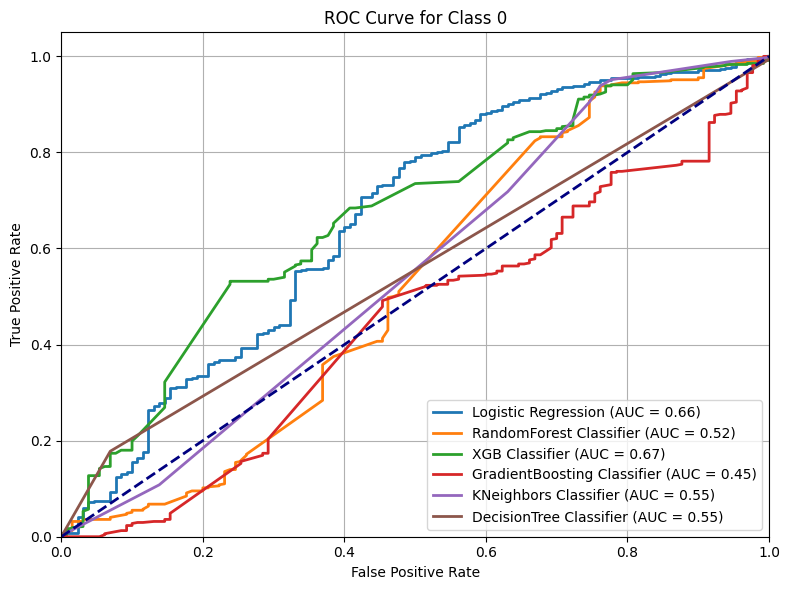

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Choose the class you want to evaluate
target_class = 0

# Ensure class index is consistent across models
class_index = list(dt.classes_).index(target_class)

# Binarize labels for OvR evaluation
y_test_bin = label_binarize(y_test, classes=dt.classes_)

# Define your models
models = {
    'Logistic Regression': lr,
    'RandomForest Classifier': rf,
    'XGB Classifier': xgb,
    'GradientBoosting Classifier': gb,
    'KNeighbors Classifier': knn,
    'DecisionTree Classifier': dt
}

# Plotting
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    y_score = y_proba[:, class_index]

    # Compute ROC components
    fpr, tpr, _ = roc_curve(y_test_bin[:, class_index], y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Class {target_class}')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but K

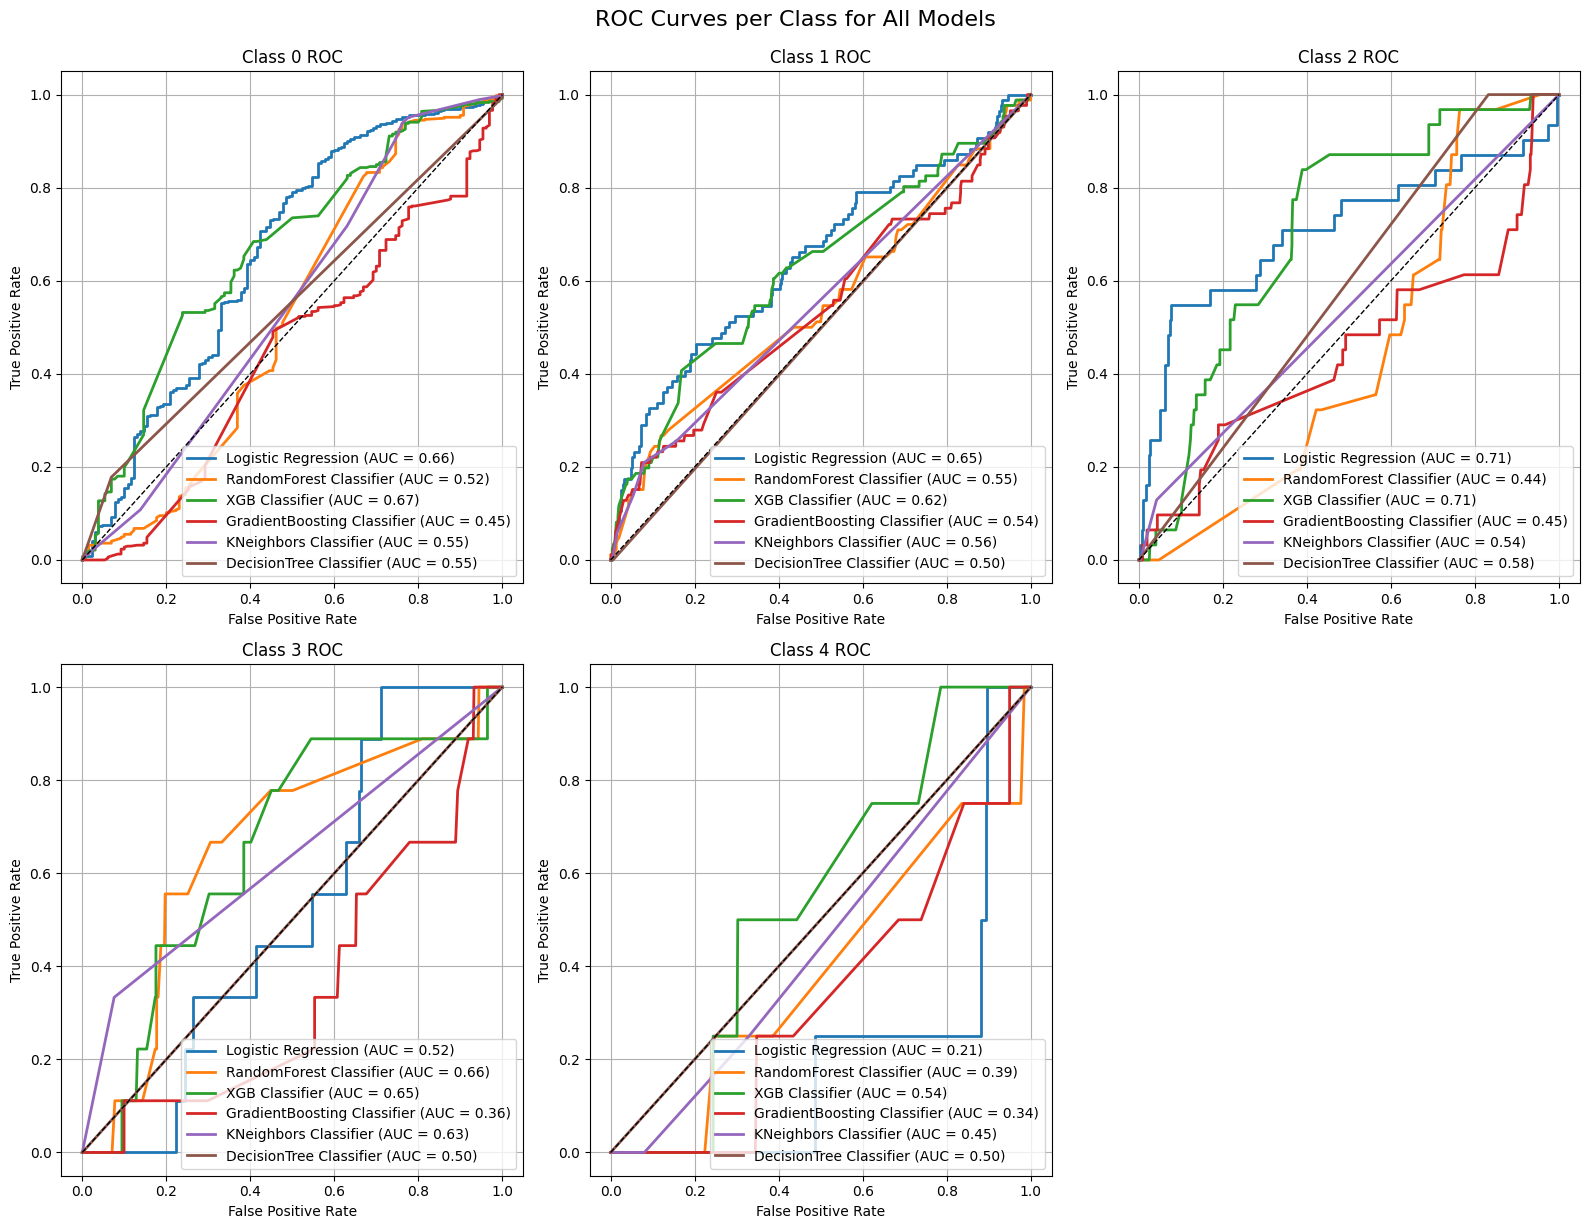

In [83]:
# Binarize true labels
y_test_bin = label_binarize(y_test, classes=lr.classes_)
n_classes = y_test_bin.shape[1]

# Define your models
models = {
    'Logistic Regression': lr,
    'RandomForest Classifier': rf,
    'XGB Classifier': xgb,
    'GradientBoosting Classifier': gb,
    'KNeighbors Classifier': knn,
    'DecisionTree Classifier': dt
}

# Plot setup
plt.figure(figsize=(16, 12))

for class_idx in range(n_classes):
    plt.subplot(2, (n_classes+1)//2, class_idx+1)
    
    for name, model in models.items():
        y_score = model.predict_proba(X_test)[:, class_idx]
        fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {class_idx} ROC')
    plt.legend(loc="lower right")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("ROC Curves per Class for All Models", fontsize=16, y=1.02)
plt.savefig('roc_auc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

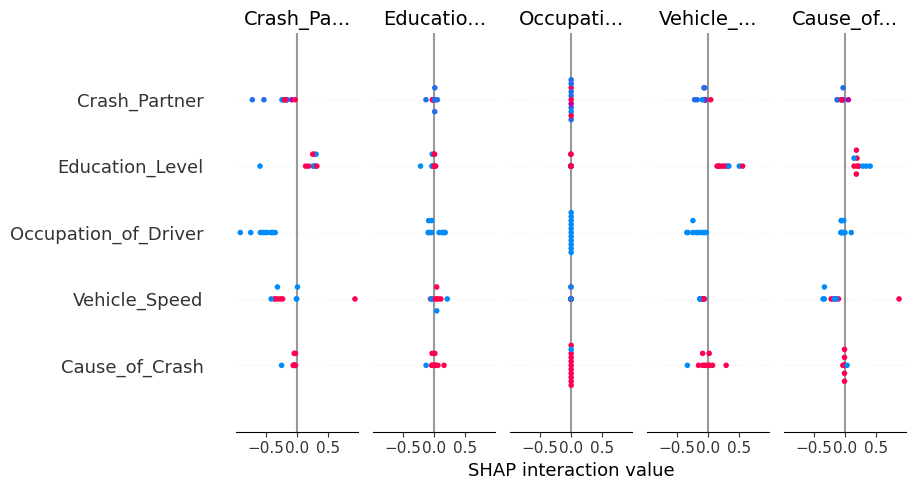

In [99]:
# import shap
# Choose a tree-based model (e.g., XGBoost, RandomForest, GradientBoosting)
model = xgb  # or rf, gb, etc.

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

X_sample = X_test_trf[:11]  # keep it consistent
shap_values = explainer.shap_values(X_sample)
feature_names = X_train.columns.tolist()
shap.summary_plot(shap_values,X_sample,feature_names, show=False)
plt.gcf().set_size_inches(12,5)
plt.tight_layout()
plt.show()

In [81]:
# # Add feature names to SHAP plot
# feature_names = X_train.columns.tolist()  # Your actual column names
# shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
# plt.gcf().set_size_inches(16,4)  # Better ratio    # Leave space for headers
# plt.show()

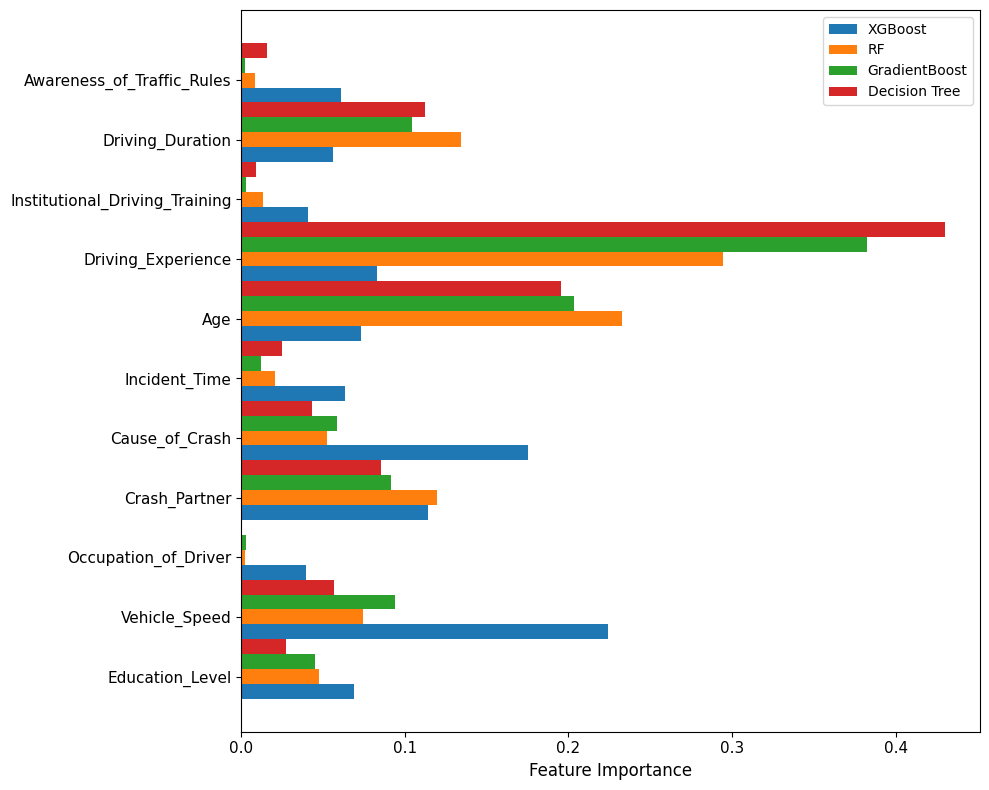

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from each model
feature_names = X_train.columns
importances = {
    'XGBoost': xgb.feature_importances_,
    'RF': rf.feature_importances_, 
    'GradientBoost': gb.feature_importances_, 
    'Decision Tree': dt.feature_importances_, # or your AdaBoost model
    
}

# Create comparison plot
fig, ax = plt.subplots(figsize=(10, 8))
x = np.arange(len(feature_names))
width = 0.25

for i, (name, importance) in enumerate(importances.items()):
    ax.barh(x + i*width, importance, width, label=name)

ax.set_yticks(x + width)
ax.set_yticklabels(feature_names)
ax.set_xlabel('Feature Importance')
ax.legend()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression      0.75       0.65    0.75      0.70
1                  KNN      0.82       0.78    0.82      0.78
2        Decision Tree      0.70       0.74    0.70      0.72
3       Gradient Boost      0.79       0.75    0.79      0.76
4              XGBoost      0.83       0.81    0.83      0.80
5        Random Forest      0.78       0.76    0.78      0.77


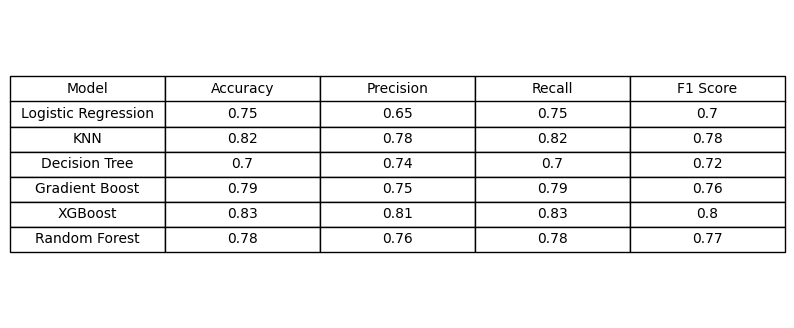

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# Example data: replace these with your actual model names and scores
model_metrics = {
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Gradient Boost', 'XGBoost', 'Random Forest'],
    'Accuracy': [0.75, 0.82, 0.70, 0.79,0.83,0.78],
    'Precision': [0.65, 0.78, 0.74, 0.75,0.81,0.76],
    'Recall': [0.75, 0.82, 0.70, 0.79,0.83,0.78],
    'F1 Score': [0.70, 0.78, 0.72, 0.76,0.80,0.77]
}

# Create the DataFrame
metrics_df = pd.DataFrame(model_metrics)

# Display it
print(metrics_df)
# Plot table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Save as image
plt.savefig('model_metrics.png', bbox_inches='tight', dpi=300)